In [148]:
import re
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from functools import partialmethod
pd.DataFrame.head = partialmethod(pd.DataFrame.head, n=2)
from gensim.corpora import Dictionary
from sklearn import preprocessing
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
from bs4 import BeautifulSoup
import html as ihtml
import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, plot_roc_curve, classification_report

In [3]:
# 18 fields expected.
field_names = ['id', 'type', 'is_best_answer', 'topic_id', 'parent_id', 'votes',
               'title', 'content', 'member', 'category', 'state', 'is_solved', 'num_answers',
               'country', 'date', 'last_answer_date', 'author_crc', 'visits']


txt_path = "export-forums_en.csv"
entity_path = "export-forums_en.pickle"
csv_path = "export-forums_en.format.csv"
data_path = ""

def format_entities():
    '''
    Read the raw data, format the list of entities, serialize them.
    '''

    def build_entities(txt_path, max_entities=None):
        '''
        Return a list of structured entities from raw txt file.
        '''
        # Read text file.
        with open(txt_path, 'r', encoding='utf8') as f:
            # Entities and current entity.
            entities, entity = [], {}
            # Entity values might be split over lines
            field_counter = 0
            # Process lines
            for line in f:
                # Change value
                line = line.replace("\\N", '"unkwown"')
                # Char start for extracted value.
                char_start = 1
                # Find values separators
                field_index = [m.start() for m in re.finditer('","', line)]
                # Browse value separators.
                for index in field_index:
                    # Extract in between value.
                    value = line[char_start:index]
                    # Update start index.
                    char_start = index + 3
                    # Update field counter.
                    field_counter += 1
                    # Update entity value.
                    try:
                        entity[field_names[field_counter-1]] += value
                    except KeyError:
                        entity[field_names[field_counter-1]] = value
                    except IndexError:
                        entity = {}
                        field_counter = 0
                # Content string is split.
                if field_counter == 7 and len(field_index) > 0:
                    entity[field_names[7]] = line[field_index[-1]:]
                    continue
                # Next content string.
                if field_counter == 7 and len(field_index) == 0:
                    entity[field_names[7]] += line
                    continue
                # Next entity.
                if len(entity) == 17:
                    field_counter = 0
                    entities.append(entity)
                    entity = {}
                    if max_entities is not None:
                        if len(entities) > max_entities:
                            return entities
        return entities

    # Write entities on disk.
    with open(entity_path, 'wb') as f:
        pickle.dump(build_entities(txt_path=txt_path, max_entities=None), f)

In [31]:
format_entities()

# 1. Data Exploration

In [4]:
with open(entity_path, 'rb') as obj:
        entities = pickle.load(obj)
df = pd.DataFrame(entities)
print(df.shape)
df.head()

(715516, 17)


,id,type,is_best_answer,topic_id,parent_id,votes,title,content,member,category,state,is_solved,num_answers,country,date,last_answer_date,author_crc
0,69561,C,0,4,36102,0,Windows Vista to XP Downgrading/Reformat?,<a href='http://paparadit.blogspot.com/2007/06...,0,136,0,1,180,IN,1234889592,1306387514,865612499
1,587308,C,0,4,17183,0,Windows Vista to XP Downgrading/Reformat?,but my does not have where to off the SATA. wh...,0,136,0,1,180,unkwown,1304428703,1306387514,1949389026


In [79]:
table1 = []
for col in df.columns:
    table1.append((col, df[col].nunique(), df[col].isnull().sum(),  df[col].dtype))
    
table1_df = pd.DataFrame(table1, columns=['Variable Name', 'Unique Value', 'Missing Value', 'Data Type'])
table1_df

,Variable Name,Unique Value,Missing Value,Data Type
0,id,715516,0,object
1,type,3,0,object
2,is_best_answer,2,0,object
3,topic_id,264962,0,object
4,parent_id,248145,0,object
5,votes,526,0,object
6,title,220334,0,object
7,content,652753,0,object
8,member,4,0,object
9,category,107,0,object


In [6]:
# convert data types
num_cols = ['is_best_answer','topic_id','parent_id','votes','member','state',
              'is_solved','num_answers','date','last_answer_date','author_crc']
df[num_cols] = df[num_cols].apply(pd.to_numeric)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715516 entries, 0 to 715515
Data columns (total 17 columns):
id                  715516 non-null object
type                715516 non-null object
is_best_answer      715516 non-null int64
topic_id            715516 non-null int64
parent_id           715516 non-null int64
votes               715516 non-null int64
title               715516 non-null object
content             715516 non-null object
member              715516 non-null int64
category            715516 non-null object
state               715516 non-null int64
is_solved           715516 non-null int64
num_answers         715516 non-null int64
country             715516 non-null object
date                715516 non-null int64
last_answer_date    715516 non-null int64
author_crc          715516 non-null int64
dtypes: int64(11), object(6)
memory usage: 92.8+ MB


In [7]:
df['type'].unique()

array(['C', 'Q', 'A'], dtype=object)

In [8]:
# separate date by Question and Answer
Q = df[df['type']=='Q']
A = df[df['type']=='A']
C = df[df['type']=='C']

In [9]:
# Check if there's any questions without answer
print("Questions without answers:", round(len(Q[Q['num_answers'] == 0])/len(Q)*100),'%')

Questions without answers: 35 %


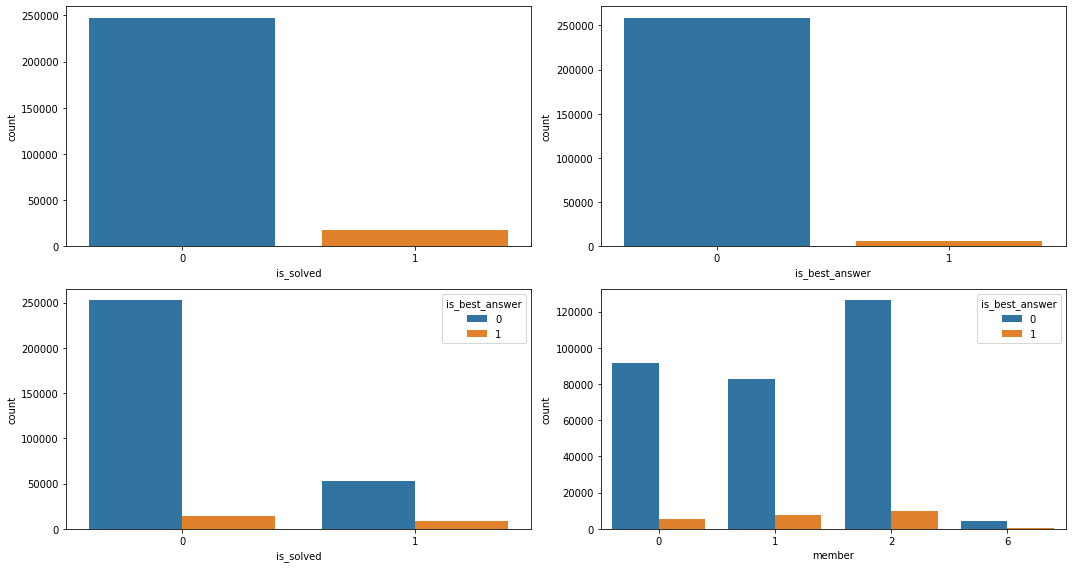

In [59]:
# explore question rows

plt.subplots(2,2, figsize=(15,8))

plt.subplot(2,2,1)
sns.countplot(Q['is_solved'])

plt.subplot(2,2,2)
sns.countplot(Q['is_best_answer'])

plt.subplot(2,2,3)
# best answer by solved/unsolved questions
sns.countplot(x='is_solved',hue='is_best_answer', data=A)

plt.subplot(2,2,4) 
# best answer by member/non-member
sns.countplot(x='member', hue='is_best_answer', data=A)

plt.tight_layout()

Some insights:
- Many questions are unsolved.
- Many questions are without best answers.
- Solved questions != existance of best answers.
- Member != more best answers.

### See the correlation to best answer 

In [85]:
A_dummy = A.drop(['id','title','content','category','date','last_answer_date','author_crc'], axis=1)
A_dummy = pd.get_dummies(A_dummy, drop_first=True)

In [87]:
A[A.columns[0:]].corr()['is_best_answer'][:]

is_best_answer      1.000000
topic_id           -0.090386
parent_id          -0.090386
votes               0.158308
member              0.024132
state               0.134392
is_solved           0.127521
num_answers        -0.051868
date               -0.099104
last_answer_date   -0.086181
author_crc         -0.002397
Name: is_best_answer, dtype: float64

- There are very low correlatons to target variable.
- Let's use texts to predict the best answers

# 2. Data Cleaning

Drop useless columns and calculate the duration from date variables

In [9]:
df.drop(['id','topic_id', 'parent_id', 'title', 'author_crc'], axis=1, inplace=True)

In [10]:
# Calculate the duration from active date
df['duration'] = df['last_answer_date'] - df['date']

# Drop all the date columns except durations
df.drop(['date','last_answer_date'], axis=1, inplace=True)
df.head()

,type,is_best_answer,votes,content,member,category,state,is_solved,num_answers,country,duration
0,C,0,0,<a href='http://paparadit.blogspot.com/2007/06...,0,136,0,1,180,IN,71497922
1,C,0,0,but my does not have where to off the SATA. wh...,0,136,0,1,180,unkwown,1958811


### Encoding

In [11]:
# Label Encoding
encoder = preprocessing.LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
df['country'] = encoder.fit_transform(df['country'])
# OneHot Encoding
df['type'] = pd.get_dummies(df['type'], drop_first=True)

### Clean text

In [15]:
def clean_sentences(sentences):
    tokens = []
    
    for sentence in sentences:
        text = re.sub('http.*', '', sentence)
        soup = BeautifulSoup(text, 'lxml')
        a = soup.get_text()
        t = a.strip()
        token = word_tokenize(t)
        token = [w.lower() for w in token]
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in token]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        tokens.append(words)

    return tokens

In [16]:
df['content'] = clean_sentences(df['content'])

/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:294: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:294: UserWarning: "b'q'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:294: UserWarning: "b'/'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/

In [19]:
df.to_csv('df_cleaned.csv', index=False)

# 3. Embedding

In [20]:
df = pd.read_csv('df_cleaned.csv')
df.shape

(715516, 11)

### Word2Vec

In [115]:
model_w2v = Word2Vec(df['content'], min_count = 1,size = 50,workers = 3, window = 3, sg = 1)
model_w2v[model_w2v.wv.vocab]

/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([[ 0.13320264,  0.17137007,  0.32646728, ...,  0.11159281,
        -0.05239496,  0.09800506],
       [-0.04390059,  0.09281673,  0.24007897, ...,  0.11470777,
        -0.17819491, -0.20687735],
       [-0.08421148,  0.10757275,  0.00295816, ..., -0.09031783,
        -0.14897063,  0.00235167],
       ...,
       [ 0.09052853, -0.0436186 ,  0.15057436, ..., -0.11169223,
        -0.16641518,  0.03265886],
       [ 0.09871047, -0.02158335,  0.12490938, ..., -0.09042915,
        -0.1681223 ,  0.00408205],
       [ 0.10138465, -0.02664928,  0.07545383, ..., -0.08208122,
        -0.15304162, -0.0042756 ]], dtype=float32)

In [ ]:
def build_word2vec_from_text(model_w2v, sentence, emb_size):
    emb_vec = np.zeros(emb_size).reshape((1, emb_size))
    count = 0.
    for word in sentence:
        try:
            emb_vec += model_w2v[word].reshape((1, emb_size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        emb_vec /= count
    return emb_vec

df['content'] = np.concatenate([build_word2vec_from_text(model_w2v, d, 50) for d in df['content']], axis=0)

### Resampling

In [117]:
best = df['is_best_answer'].values
y = np.array(best.copy())
X = df.drop(columns=['is_best_answer']).values
y = (y > 0)*1

nb_class = len(set(y))
nb_class

# create empty arrays for both classes
id_Train = np.array([None]*nb_class)
id_Test = np.array([None]*nb_class)

for i in range(nb_class):
    id_i = np.where(y==i)[0]
    id_i_train, id_i_test = train_test_split(id_i, test_size=0.3)
    id_Train[i] = id_i_train
    id_Test[i] = id_i_test
    
id_Train = np.concatenate(id_Train)
id_Test = np.concatenate(id_Test)

X_train = X[id_Train]
X_test = X[id_Test]
y_train = y[id_Train]
y_test = y[id_Test]

id_toTrain = np.array([np.where(y_train==i)[0] for i in range(nb_class)])

In [118]:
size_max = [len(id_toTrain[i]) for i in range(nb_class)]
print("Before Resampling", size_max)

blc = 800
for i in range(len(size_max)):
    if size_max[i] > blc:
        size_max[i] = int(blc*(np.log10(size_max[i]/blc)+100))
    else:
        size_max[i] = int(blc/(np.log10(blc/size_max[i])+0.05))
        
print("After Resampling", size_max)

Before Resampling [480253, 20607]
After Resampling [82222, 81128]


In [97]:
for i in range(nb_class):
    if len(id_toTrain[i]) > size_max[i]:
        id_toTrain[i], tmp = train_test_split(id_toTrain[i], test_size=1-size_max[i]/len(id_toTrain[i]))
    else:
        id_toTrain[i] = np.concatenate((id_toTrain[i], id_toTrain[i][np.random.randint(len(id_toTrain[i]), size=int(size_max[i]-len(id_toTrain[i])))]))
id_toTrain = np.concatenate(id_toTrain)
X_train = X_train[id_toTrain]
y_train = y_train[id_toTrain]

print(Counter(y_train))

Counter({0: 106222, 1: 105128})


In [119]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.columns = ['type', 'votes', 'content', 'member', 'category', 'state', 'is_solved', 'num_answers', 'country', 'duration']
X_test.columns = ['type', 'votes', 'content', 'member', 'category', 'state', 'is_solved', 'num_answers', 'country', 'duration']

# 4. Modelling

### Xgboost

In [122]:
xgb = XGBClassifier(
    learning_rate=0.1, max_depth=5,
    min_child_weight=10, min_samples_leaf=5, min_samples_split=5,
    n_estimators=50, objective='binary:logistic')

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict_proba(X_test)[:,0]

In [123]:
print("ROC-AUC", roc_auc_score(y_test, y_pred_xgb))
print("Confusion Matrix")
print(classification_report(y_test, y_pred_xgb))

ROC-AUC 0.8397378131421696
Confusion Matrix
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    205824
           1       0.85      0.68      0.76      8832

    accuracy                           0.98    214656
   macro avg       0.92      0.84      0.87    214656
weighted avg       0.98      0.98      0.98    214656



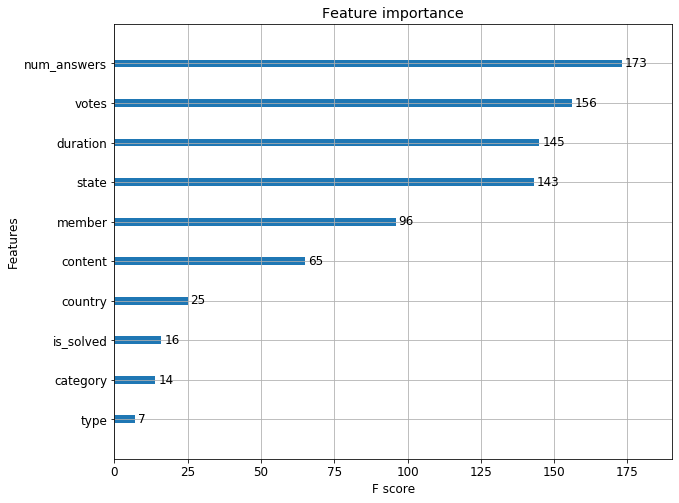

In [155]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = plot_importance(xgb, importance_type = 'weight', max_num_features=10, ax=ax)
plt.rc('font', size=15)
plt.show()

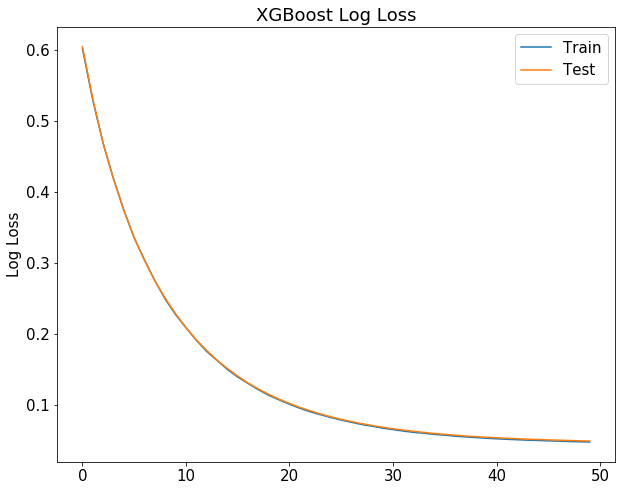

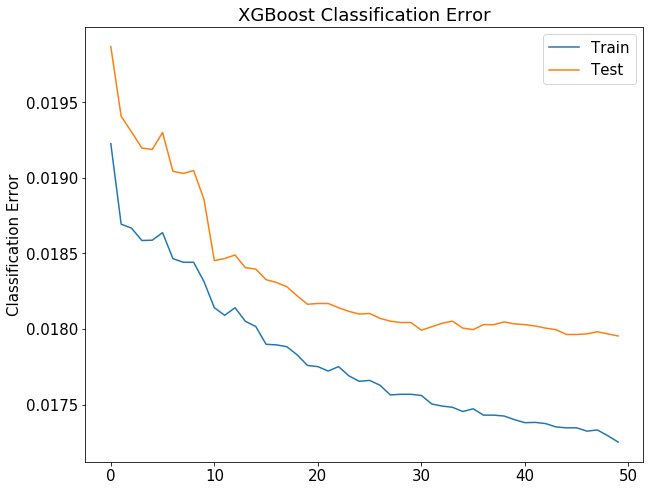

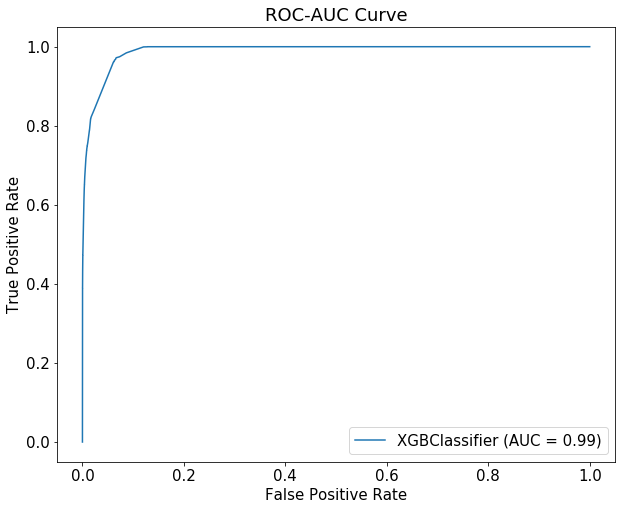

In [164]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train, eval_metric=["error","logloss"], eval_set=eval_set, verbose=0)
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.rc('font', size=15)
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.rc('font', size=15)
plt.show()

# plot ROC-AUC curve
plt.subplots(1, 1, figsize=(10, 8))
ax = plt.subplot(1,1,1)
plt.title('ROC-AUC Curve')
plt.rc('font', size=15)
plot_roc_curve(xgb, X_test, y_test, ax=ax)

### Neural Network

In [142]:
nn = Sequential()
nn.add(Dense(1, input_shape=(10,), activation='sigmoid'))
sgd = optimizers.SGD(lr=0.5) # learning rate
nn.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [143]:
nn.fit(X_train, y_train, batch_size=25, epochs=1, verbose=0)

In [144]:
y_pred_nn = nn.predict(X_test).ravel()
results = nn.evaluate(X_test, y_test, batch_size=128, verbose=0)
print('Test Loss, Test Accuracy:', results)

Test Loss, Test Accuracy: [0.07971669478951712, 0.92026776]


## Achieved 92% Accuracy with 0.08 MSE !!!